In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import copy
import os
from bisect import bisect_left
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from six.moves import xrange
import enum
import tensorflow as tf

from cleverhans.attacks import FastGradientMethod
from cleverhans.loss import CrossEntropy
from cleverhans.dataset import MNIST
from cleverhans.model import Model
from cleverhans.picklable_model import MLP, Conv2D, ReLU, Flatten, Linear, Softmax
from cleverhans.train import train
from cleverhans.utils_tf import batch_eval, model_eval
from cleverhans import serial
from pathlib import Path

from dknn import DkNNModel, get_tensorflow_session, make_basic_picklable_cnn, NearestNeighbor
from utils_config import get_config_parameters

from utils_kernel import euclidean_kernel, hard_geodesics_euclidean_kernel
from utils_visualization import plot_kernel

In [2]:
config = get_config_parameters('../configs/config_mnist.yaml')

In [3]:
mnist = MNIST(train_start=0, train_end=config['nb_train'], test_start=0, test_end=config['nb_test'])
x_train, y_train = mnist.get_set('train')
x_test, y_test = mnist.get_set('test')

# Use Image Parameters.
img_rows, img_cols, nchannels = x_train.shape[1:4]
nb_classes = y_train.shape[1]

In [5]:
with get_tensorflow_session(config) as sess:
    with tf.variable_scope('dknn'):
        # Define input TF placeholder.
        x = tf.placeholder(tf.float32, shape=(
          None, img_rows, img_cols, nchannels))
        y = tf.placeholder(tf.float32, shape=(None, nb_classes))

        # Define a model.
        model = make_basic_picklable_cnn()
        preds = model.get_logits(x)
        loss = CrossEntropy(model, smoothing=0.)

        # Define the test set accuracy evaluation.
        def evaluate():
            acc = model_eval(sess, x, y, preds, x_test, y_test,
                             args={'batch_size': config['batch_size']})
            print('Test accuracy on test examples: %0.4f' % acc)

        # Train the model
        train_params = {'nb_epochs': config['max_epochs'],
                      'batch_size': config['batch_size'], 'learning_rate': config['learning_rate']}

        data_filepath = "model.joblib"
        path = Path(data_filepath)

        if path.is_file():
            model = serial.load(data_filepath)
        else:
            train(sess, loss, x_train, y_train, evaluate=evaluate,
              args=train_params, var_list=model.get_params())
            serial.save("model.joblib", model)

          # Define callable that returns a dictionary of all activations for a dataset
        def get_activations(data):
            data_activations = {}
            for layer in layers:
                layer_sym = tf.layers.flatten(model.get_layer(x, layer))
                data_activations[layer] = batch_eval(sess, [x], [layer_sym], [data],
                                                   args={'batch_size': config['batch_size']})[0]
            return data_activations

        # Use a holdout of the test set to simulate calibration data for the DkNN.
        train_data = x_train
        train_labels = np.argmax(y_train, axis=1)
        cali_data = x_test[:config['nb_cali']]
        y_cali = y_test[:config['nb_cali']]
        cali_labels = np.argmax(y_cali, axis=1)
        test_data = x_test[config['nb_cali']:]
        y_test = y_test[config['nb_cali']:]

        # Extract representations for the training and calibration data at each layer of interest to the DkNN.
        layers = ['ReLU1', 'ReLU3', 'ReLU5', 'logits']

        #Euclidean DKNN
        dknn = DkNNModel(
        neighbors = config['nb_neighbors'],
        proto_neighbors = config['nb_proto_neighbors'],
        layers=layers,
        get_activations=get_activations,
        train_data=train_data,
        train_labels=train_labels,
        nb_classes=nb_classes,
        backend = config['backend'],
        method='euclidean',
        scope='dknn')

        # Geodesic DKNN
        dknn_geod = DkNNModel(
        neighbors = config['nb_neighbors'],
        proto_neighbors = config['nb_proto_neighbors'],
        layers=layers,
        get_activations=get_activations,
        train_data=train_data,
        train_labels=train_labels,
        nb_classes=nb_classes,
        backend = config['backend'],
        method='geodesic',
        scope='dknn')





Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


/Users/cchallu/anaconda3/envs/dknn_geod/lib/python3.6/site-packages/cleverhans/utils_tf.py:294: UserWarning: batch_eval has moved to cleverhans.evaluation. batch_eval will be removed from utils_tf on or after 2019-03-09.
  warnings.warn("batch_eval has moved to cleverhans.evaluation. "
/Users/cchallu/anaconda3/envs/dknn_geod/lib/python3.6/site-packages/cleverhans/evaluation.py:376: UserWarning: `args` is deprecated and will be removed on or after 2019-03-09. Pass `batch_size` directly.
  warnings.warn("`args` is deprecated and will be removed on or "


Constructing the NearestNeighbor table
Constructing the NearestNeighbor table
Constructing the NearestNeighbor table
Constructing the NearestNeighbor table
Constructing the NearestNeighborGeodesic table
Constructing the NearestNeighborGeodesic table
Constructing the NearestNeighborGeodesic table
Constructing the NearestNeighborGeodesic table


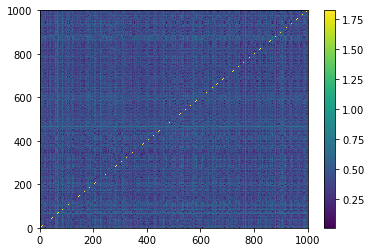

In [6]:
euclidean_matrix = euclidean_kernel(dknn.train_activations['ReLU1'])
max_distance = np.max(euclidean_matrix)+1
euclidean_matrix[euclidean_matrix == 0]=max_distance
plot_kernel(euclidean_matrix)

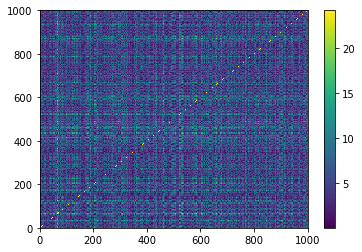

In [7]:
geodesic_euclidean_matrix = hard_geodesics_euclidean_kernel(dknn_geod.train_activations['ReLU1'], 5)
max_distance = np.max(geodesic_euclidean_matrix)+1
geodesic_euclidean_matrix[geodesic_euclidean_matrix == 0]=max_distance
plot_kernel(geodesic_euclidean_matrix)

In [10]:
ks = range(1,70)
same_class_euclidean = np.zeros(len(ks))
same_class_geodesic = np.zeros(len(ks))
for j,k in enumerate(ks):
    acum_euc = 0
    acum_geo = 0
    for i in range(1000):
        euclidean_neighbors_idx = np.argpartition(euclidean_matrix[i,:],k)[:k]
        acum_euc += np.mean(train_labels[i]==train_labels[euclidean_neighbors_idx])

        #geodesic_neighbors_idx = np.argpartition(geodesic_euclidean_matrix[i,:],k)[:k]
        #acum_geo += np.mean(train_labels[i]==train_labels[geodesic_neighbors_idx])
        acum_geo += np.mean(train_labels[i]==train_labels[dknn_geod.query_objects['ReLU1'].train_neighbor_index[i,:k]])
    same_class_euclidean[j] = acum_euc/1000
    same_class_geodesic[j] = acum_geo/1000
    #print(j)

Text(0, 0.5, '% of NN with same class')

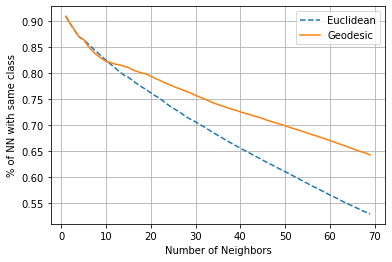

In [11]:
plt.plot(range(1,70),same_class_euclidean, label='Euclidean', linestyle='--')
plt.plot(range(1,70),same_class_geodesic, label='Geodesic')
plt.legend()
plt.grid()
plt.xlabel('Number of Neighbors')
plt.ylabel('% of NN with same class')
plt.savefig('../results/comformity_comparison_relu1.png')